In [1]:
# import numpy as np
# import pandas as pd
# from pathlib import Path

# input_path = Path('./output/amex-default-prediction/')

# def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

#     def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
#         df = (pd.concat([y_true, y_pred], axis='columns')
#               .sort_values('prediction', ascending=False))
#         df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
#         four_pct_cutoff = int(0.04 * df['weight'].sum())
#         df['weight_cumsum'] = df['weight'].cumsum()
#         df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
#         return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
#     def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
#         df = (pd.concat([y_true, y_pred], axis='columns')
#               .sort_values('prediction', ascending=False))
#         df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
#         df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
#         total_pos = (df['target'] * df['weight']).sum()
#         df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
#         df['lorentz'] = df['cum_pos_found'] / total_pos
#         df['gini'] = (df['lorentz'] - df['random']) * df['weight']
#         return df['gini'].sum()

#     def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
#         y_true_pred = y_true.rename(columns={'target': 'prediction'})
#         return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

#     g = normalized_weighted_gini(y_true, y_pred)
#     d = top_four_percent_captured(y_true, y_pred)

#     return 0.5 * (g + d)

# # amex_metric(train_agged['target'].to_frame(), pd.Series(pred_prob[:,1],name='prediction'))
# amex_metric(train_agged['target'].to_frame(), pd.Series(pred,name='prediction'))

In [1]:
import numpy as np
import pandas as pd
import lightgbm
import gc
from sklearn.metrics import f1_score,accuracy_score

import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss,roc_auc_score
from sklearn.model_selection import StratifiedKFold,KFold
import warnings
warnings.filterwarnings('ignore')
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
to_prefix = './output/american_express/'

optuna调参LGBM

'n_estimators': 2800, 'learning_rate': 0.03, 'num_leaves': 800, 'max_depth': 6, 'min_data_in_leaf': 1300, 'lambda_l1': 0.08, 'lambda_l2': 0.65, 'min_gain_to_split': 8, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 1.0}. Best is trial 0 with value: 0.21780318017101002.

In [7]:
# 搜索5折交叉验证最优的超参数
def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 500, 4000, step=100),  # "n_estimators":1000, #
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.08, step=0.01),  # "learning_rate": 0.05, # 
        "num_leaves": trial.suggest_int("num_leaves", 200, 3000, step=100),
        "max_depth": trial.suggest_int("max_depth", 5, 12),  #"max_depth": 9,  #
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 3000, step=100),
        "reg_alpha": trial.suggest_float("lambda_l1", 0, 1, step=0.02),
        "reg_lambda": trial.suggest_float("lambda_l2", 0, 1, step=0.05),
        "min_gain_to_split": trial.suggest_int("min_gain_to_split", 2, 10, step=1),  #"min_gain_to_split": 5, # 
        # "bagging_fraction": 0.8,
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.8, step=0.1
        ),
        "bagging_freq":1, # "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        # 'feature_fraction': 0.9,
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 1, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20220731)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X.index, y)):
        # X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        # y_train, y_test = y[train_idx], y[test_idx]

        model = lightgbm.LGBMClassifier(objective="binary", verbose=-1, **param_grid)
        model.fit(
            X.iloc[train_idx], # X_train,
            y[train_idx], # y_train,
            # eval_set=[(X_test, y_test)],
            eval_set=[(X.iloc[test_idx], y[test_idx])],
            # eval_metric="binary_logloss",
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        # preds = model.predict_proba(X_test)
        # cv_scores[idx] = log_loss(y_test, preds)
        preds = model.predict_proba(X.iloc[test_idx])
        cv_scores[idx] = log_loss(y[test_idx], preds)
        # cv_scores[idx] = f1_score(y_test, preds)

    return np.mean(cv_scores)

def display_importances(feature_importance_df_, num=4000):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:num].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)] # 平均重要性排前40的特征
    plt.figure(figsize=(8, 40))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances01.png')
    return cols

In [3]:
train_data = pd.read_pickle(to_prefix+'train_data_agged.pkl')
print(train_data.shape)

bin_woe = pd.read_csv(to_prefix+'train_data_bin100_woe.csv')
feature_iv_df = bin_woe[['feature','iv']].groupby('feature').sum().sort_values('iv',ascending=False)
drop_feats = feature_iv_df['iv'][feature_iv_df['iv']==0].index.tolist()

train_data.drop(drop_feats, axis=1, inplace=True)

(458913, 3728)


In [13]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, train_data.iloc[:,:-1], train_data['target'])
study.optimize(func, n_trials=5)

[I 2022-08-14 21:49:31,266] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4
[LightGBM] [Warning] min_data_in_leaf is set=7

[I 2022-08-14 21:55:24,053] Trial 0 finished with value: 0.22186921244006128 and parameters: {'n_estimators': 2700, 'learning_rate': 0.060000000000000005, 'num_leaves': 2300, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 0.38, 'lambda_l2': 1.0, 'min_gain_to_split': 4, 'bagging_fraction': 0.2, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.22186921244006128.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-14 22:03:07,032] Trial 1 finished with value: 0.21933073775237397 and parameters: {'n_estimators': 1000, 'learning_rate': 0.08, 'num_leaves': 2800, 'max_depth': 7, 'min_data_in_leaf': 2700, 'lambda_l1': 0.9, 'lambda_l2': 0.7000000000000001, 'min_gain_to_split': 3, 'bagging_fraction': 0.5, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.21933073775237397.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=8, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=8, min_split_gain=0.0 will be ignored. Current value: min_

[I 2022-08-14 22:32:43,783] Trial 2 finished with value: 0.2177460620573482 and parameters: {'n_estimators': 1200, 'learning_rate': 0.02, 'num_leaves': 1100, 'max_depth': 8, 'min_data_in_leaf': 1000, 'lambda_l1': 0.28, 'lambda_l2': 0.75, 'min_gain_to_split': 8, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 1.0}. Best is trial 2 with value: 0.2177460620573482.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4, min_split_gain=0.0 will be ignored. Current value: 

[I 2022-08-14 22:52:39,808] Trial 3 finished with value: 0.21704080286358035 and parameters: {'n_estimators': 1600, 'learning_rate': 0.02, 'num_leaves': 1700, 'max_depth': 8, 'min_data_in_leaf': 1800, 'lambda_l1': 0.9, 'lambda_l2': 0.75, 'min_gain_to_split': 4, 'bagging_fraction': 0.7, 'feature_fraction': 0.30000000000000004}. Best is trial 3 with value: 0.21704080286358035.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=9, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=9, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9
[LightGBM] [Warning] min_data_in_leaf is set

[I 2022-08-14 23:05:50,411] Trial 4 finished with value: 0.21870839796669053 and parameters: {'n_estimators': 1900, 'learning_rate': 0.05, 'num_leaves': 2200, 'max_depth': 9, 'min_data_in_leaf': 3000, 'lambda_l1': 0.26, 'lambda_l2': 0.4, 'min_gain_to_split': 9, 'bagging_fraction': 0.5, 'feature_fraction': 0.8}. Best is trial 3 with value: 0.21704080286358035.


In [14]:
print(f"\tBest value: {study.best_value:.5f}")  # 0.22192 对应提交 0.783。 3000特征上，0.21911对应提交0.792
print(f"\tBest params:")
study.best_params

	Best value: 0.21704
	Best params:


{'n_estimators': 1600,
 'learning_rate': 0.02,
 'num_leaves': 1700,
 'max_depth': 8,
 'min_data_in_leaf': 1800,
 'lambda_l1': 0.9,
 'lambda_l2': 0.75,
 'min_gain_to_split': 4,
 'bagging_fraction': 0.7,
 'feature_fraction': 0.30000000000000004}

#### 三、根据最优参数训练、预测、提交

In [4]:
param = { # 0.769
    'n_estimators': 10000,'learning_rate': 0.05,
    'num_leaves': 256,'max_depth': 9,'min_data_in_leaf': 1000,
    'lambda_l1': 25,'lambda_l2': 70,'min_gain_to_split': 5,
    'bagging_fraction': 0.8,'bagging_freq': 1,'feature_fraction': 0.9,
    'boosting_type':'gbdt',
    'n_jobs':-1
}
param = { # 0.771
    'n_estimators': 2800,'learning_rate': 0.05,
    'num_leaves': 2320,'max_depth': 9,'min_data_in_leaf': 200,
    'lambda_l1': 0,'lambda_l2': 30,'min_gain_to_split': 5,
    'bagging_fraction': 0.8,'bagging_freq': 1,'feature_fraction': 0.9,
    'boosting_type':'gbdt',
    'n_jobs':-1
}

param = {
    'n_estimators': 5000,'learning_rate': 0.05,
    'num_leaves': 2250,'max_depth': 12,'min_data_in_leaf': 850,
    'lambda_l1': 0.58,'lambda_l2': 0.75,'min_gain_to_split': 4,
    'bagging_fraction': 0.9,'bagging_freq': 1,'feature_fraction': 0.9,
    'boosting_type':'gbdt',
    'n_jobs':-1
}
param = { # 0.8169443812317211 0.9053458934482135 提交0.783
    'n_estimators': 2500,'learning_rate': 0.01,
    'num_leaves': 1700,'max_depth': 10,'min_data_in_leaf': 1700,
    'lambda_l1': 0.36,'lambda_l2': 0.75,'min_gain_to_split': 9,
    'bagging_fraction': 0.2,'bagging_freq': 1,'feature_fraction': 0.5,
    'boosting_type':'gbdt',
    'n_jobs':-1
}
param = { # 0.8332883278201579 0.913900891890184  提交0.783
    'n_estimators': 3300,'learning_rate': 0.09,
    'num_leaves': 1900,'max_depth': 6,'min_data_in_leaf': 1000,
    'lambda_l1': 0,'lambda_l2': 0.6,'min_gain_to_split': 8,
    'bagging_fraction': 0.7,'bagging_freq': 1,'feature_fraction': 0.5,
    'boosting_type':'gbdt',
    'n_jobs':-1
}
param = { # 0.8433586601789463 0.9190478369538453 提交0.791。 3000特征上 val metric[f1, acc]:  0.8134967265402049 0.9031628950895046 提交0.792
    'n_estimators': 700,'learning_rate': 0.04,
    'num_leaves': 600,'max_depth': 11,'min_data_in_leaf': 500,
    'lambda_l1': 0.46,'lambda_l2': 0.1,'min_gain_to_split': 8,
    'bagging_fraction': 0.6,'bagging_freq': 1,'feature_fraction': 0.8,
    'boosting_type':'gbdt',
    'n_jobs':-1
}
param = { # val metric[f1, acc]:  0.8123948873192062 0.9027706655916673
    'n_estimators': 2300,'learning_rate': 0.08,
    'num_leaves': 2500,'max_depth': 11,'min_data_in_leaf': 1400,
    'lambda_l1': 0.56,'lambda_l2': 0.5,'min_gain_to_split': 6,
    'bagging_fraction': 0.8,'bagging_freq': 1,'feature_fraction': 0.7,
    'boosting_type':'gbdt',
    'n_jobs':-1
}
param = { # val metric[f1, acc]:  0.8141098365477542 0.9035987056426571
    'n_estimators': 700,'learning_rate': 0.03,
    'num_leaves': 2500,'max_depth': 8,'min_data_in_leaf': 700,
    'lambda_l1': 0.12,'lambda_l2': 0.6,'min_gain_to_split': 3,
    'bagging_fraction': 0.7,'bagging_freq': 1,'feature_fraction': 0.6,
    'boosting_type':'gbdt',
    'n_jobs':-1
}
param = { # val metric[f1, acc]:  0.8143337536780161 0.9037512393362606 提交0.792 CV
    'n_estimators': 800,'learning_rate': 0.03,
    'num_leaves': 2500,'max_depth': 8,'min_data_in_leaf': 700,
    'lambda_l1': 0.12,'lambda_l2': 0.6,'min_gain_to_split': 3,
    'bagging_fraction': 0.7,'bagging_freq': 1,'feature_fraction': 0.6,
    'boosting_type':'gbdt',
    'n_jobs':-1
}
param = {'n_estimators': 1600,
 'learning_rate': 0.02,
 'num_leaves': 1700,
 'max_depth': 8,
 'min_data_in_leaf': 1800,
 'lambda_l1': 0.9,
 'lambda_l2': 0.75,
 'min_gain_to_split': 4,
 'bagging_fraction': 0.7,
 'feature_fraction': 0.3,
 'bagging_freq': 1,
 'boosting_type':'gbdt',
 'n_jobs':-1
 }

单模型预测

In [5]:
LGBM = lightgbm.LGBMClassifier(**param)
LGBM.fit(train_data.iloc[:,:-1], train_data['target'])
print("train finished!")

# pred = LGBM.predict(val_data.iloc[:,:-1])
# f1 = f1_score(val_data['target'], pred)
# acc = accuracy_score(val_data['target'], pred)
# print("val metric[f1, acc]: ", f1, acc)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] lambda_l1 is set=0.9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4
[LightGBM] [Warning] lambda_l2 is set=0.75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.75
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
train finished!


In [6]:
del train_data,bin_woe,feature_iv_df
gc.collect()

62

In [4]:
# test_agged = pd.read_pickle(to_prefix+'test_data_agged.pkl')
# test_agged.iloc[:500000,:].to_pickle(to_prefix+'test_data_agged_p1.pkl')
# test_agged.iloc[500000:,:].to_pickle(to_prefix+'test_data_agged_p2.pkl')

In [7]:
test_agged = pd.read_pickle(to_prefix+'test_data_agged_p1.pkl')

pred_prob = LGBM.predict_proba(test_agged.reset_index(drop=True))
test_agged['prediction'] = pred_prob[:,1]
test_agged['prediction'].to_csv(to_prefix+'sample_submission0814_v2_lgb_single_p1.csv')

模型集成：5折

In [16]:
pd.concat([test_agged2.set_index('customer_ID'),test_agged['prediction']],axis=0).to_csv(to_prefix+'sample_submission0814_v2_lgb_single.csv')

In [8]:
test_agged = pd.read_pickle(to_prefix+'test_data_agged_p2.pkl')

pred_prob = LGBM.predict_proba(test_agged.reset_index(drop=True))
test_agged['prediction'] = pred_prob[:,1]
# test_agged['prediction'].to_csv(to_prefix+'sample_submission0814_v2_lgb_single_p2.csv')
test_agged2 = pd.read_csv(to_prefix+'sample_submission0814_v2_lgb_single_p1.csv')



ModuleNotFoundError: No module named 'ustomer_ID,prediction'

In [3]:
# 分步训练+预测
train_data = pd.read_pickle(to_prefix+'train_data_agged.pkl')

folds = KFold(n_splits= 5, shuffle=True, random_state=20220801)
vali_preds = np.zeros(train_data.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_data['target'])):
    clf = lightgbm.LGBMClassifier(objective="binary", verbose=-1, **param)
    clf.fit(
        train_data.iloc[train_idx, :-1], train_data.iloc[train_idx, -1],
        eval_set=[(train_data.iloc[valid_idx, :-1], train_data.iloc[valid_idx, -1])],
        # eval_metric= 'auc', 
        eval_metric="binary_logloss",
        verbose= -1, 
        early_stopping_rounds= 100
        )
    with open(to_prefix+"model/lgbm_5cv_"+str(n_fold), 'wb') as f:
        pickle.dump(clf, f)
    
    print("forecast...")
    vali_preds[valid_idx] = clf.predict_proba(train_data.iloc[valid_idx, :-1], num_iteration=clf.best_iteration_)[:, 1]

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_data.columns.tolist()[:-1]
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(train_data.iloc[valid_idx, -1], vali_preds[valid_idx])))

print('Full AUC score %.6f' % roc_auc_score(train_data['target'], vali_preds))

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.48, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=6, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
forecast...
Fold  1 AUC : 0.960986
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set

3167


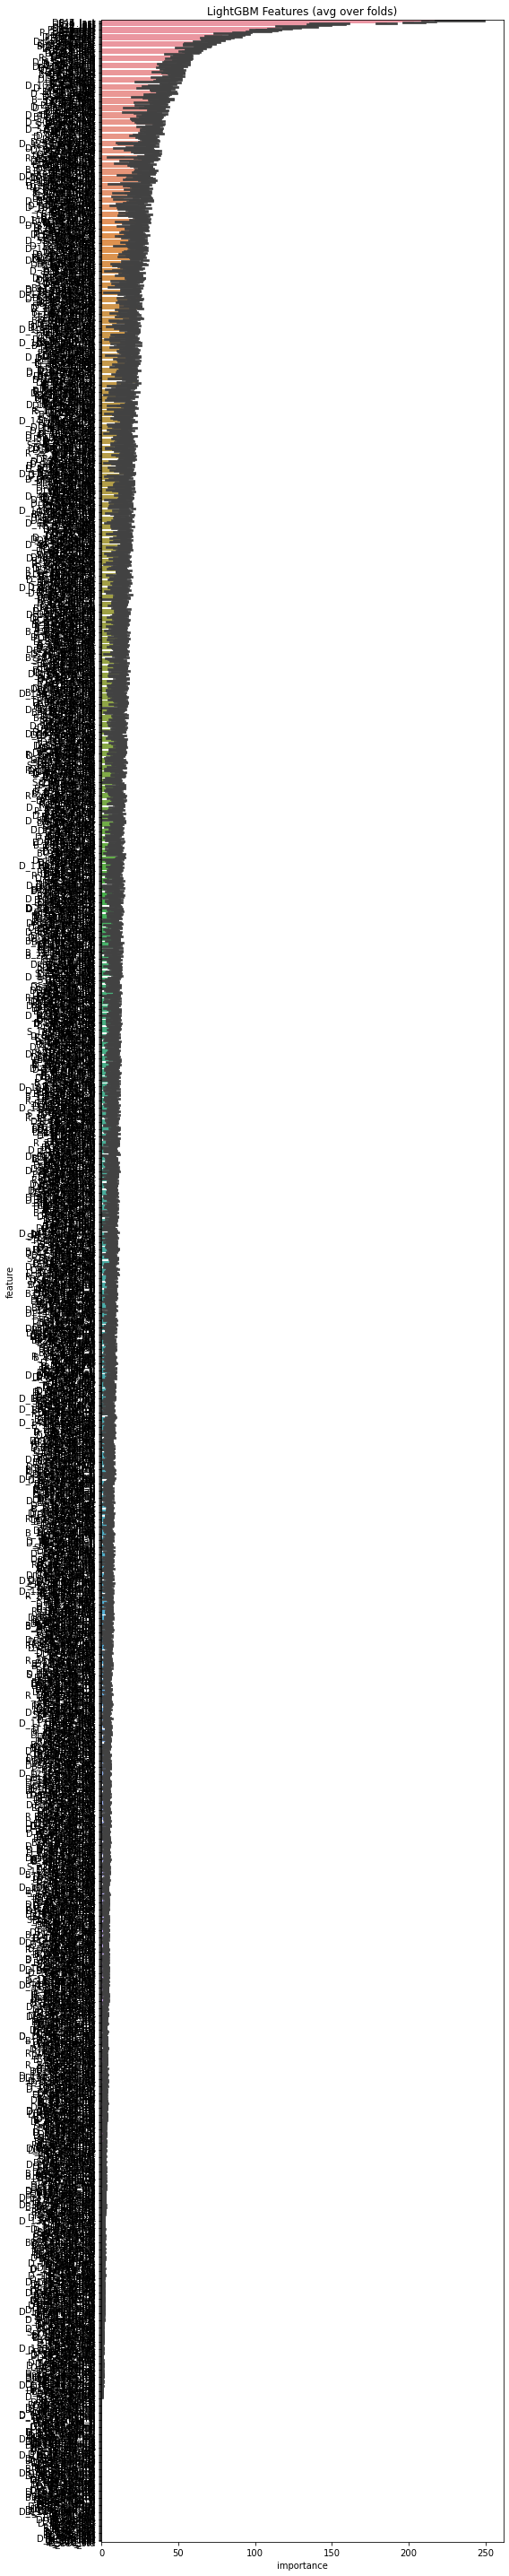

In [6]:
best_features = display_importances(feature_importance_df, 40)
print(len(best_features))
# with open('./model/best_features_by_lgb5cv','wb') as f:
#     pickle.dump(best_features,f)

In [3]:
test_data = pd.read_pickle(to_prefix+'test_data_agged.pkl')
test_preds = np.zeros(test_data.shape[0])
n_splits= 5

for i in range(n_splits):
    with open(to_prefix+"model/lgbm_5cv_"+str(i), 'rb') as f:
        clf = pickle.load(f)
    test_preds += clf.predict_proba(test_data, num_iteration=clf.best_iteration_)[:, 1] / n_splits

test_data['prediction'] = test_preds
test_data['prediction'].to_csv(to_prefix+'sample_submission0803.csv')

In [3]:
# 同时训练+预测
train_data = pd.read_pickle(to_prefix+'train_data_agged.pkl')
test_data = pd.read_pickle(to_prefix+'test_data_agged.pkl')
bin_woe = pd.read_csv(to_prefix+'train_data_bin100_woe.csv')
feature_iv_df = bin_woe[['feature','iv']].groupby('feature').sum().sort_values('iv',ascending=False)
drop_feats = feature_iv_df['iv'][feature_iv_df['iv']==0].index.tolist()

train_data.drop(drop_feats, axis=1, inplace=True)
test_data.drop(drop_feats, axis=1, inplace=True)

# folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=20220801)
folds = KFold(n_splits= 5, shuffle=True, random_state=20220801)
vali_preds = np.zeros(train_data.shape[0])
test_preds = np.zeros(test_data.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_data['target'])):
    # LightGBM parameters found by Bayesian optimization
    clf = lightgbm.LGBMClassifier(objective="binary", verbose=-1, **param)
    clf.fit(
        train_data.iloc[train_idx, :-1], train_data.iloc[train_idx, -1],
        eval_set=[(train_data.iloc[valid_idx, :-1], train_data.iloc[valid_idx, -1])],
        # eval_metric= 'auc', 
        eval_metric="binary_logloss",
        verbose= -1, 
        early_stopping_rounds= 100
        )
    
    print("forecast...")
    vali_preds[valid_idx] = clf.predict_proba(train_data.iloc[valid_idx, :-1], num_iteration=clf.best_iteration_)[:, 1]
    test_preds += clf.predict_proba(test_data, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = test_data.columns.tolist()
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(train_data.iloc[valid_idx, -1], vali_preds[valid_idx])))

print('Full AUC score %.6f' % roc_auc_score(train_data['target'], vali_preds))

test_data['prediction'] = test_preds
test_data['prediction'].to_csv(to_prefix+'sample_submission0801.csv')

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] lambda_l2 is set=0.7000000000000001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
forecast...
Fold  1 AUC : 0.961091
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM

In [ ]:
# 1. 尾部：方差153、最小值129、最大值124、均值113、求和73、
# 2. 头尾差：方差141、最大值119、最小值118、均值80、求和78、
# 3. 全部：方差155、last_150、first_132、均值128、最小值128、最大值113、求和66

In [6]:
# 特征分析
import pandas as pd
import numpy as np
import pickle

with open("./model/best_features_by_lgb5cv", 'rb') as f:
    best_feats = pickle.load(f)
print(len(best_feats))
pd.Series([i.split('_')[-1] for i in best_feats[:2000]]).value_counts()

3167


tl       606
ms       493
last     151
mean     130
min      128
var      126
std      126
first    123
max      117
dtype: int64

In [8]:
pd.Series([i.split('_')[-2] for i in best_feats[:2000] if i.split('_')[-1]=='tl']).value_counts()

min     130
mean    122
max     122
std     118
var     114
dtype: int64

In [34]:
pd.Series([i[-3:] for i in best_feats if i.split('_')[-1] not in ('tl','ms')]).value_counts()

var    155
ast    150
rst    132
ean    128
min    128
max    113
sum     66
dtype: int64

1. 尾部：方差153、最小值129、最大值124、均值113、求和73、
2. 头尾差：方差141、最大值119、最小值118、均值80、求和78、
3. 全部：方差155、last_150、first_132、均值128、最小值128、最大值113、求和66

tips: 多用头尾窗口特征以及窗口差。

In [23]:
for t in pd.Series([i[-6:] for i in best_feats]).value_counts().items():
    print(t)

('var_tl', 153)
('var_ms', 141)
('_first', 132)
('min_tl', 129)
('max_tl', 124)
('max_ms', 119)
('min_ms', 118)
('ean_tl', 113)
('ean_ms', 80)
('sum_ms', 78)
('sum_tl', 73)
('2_last', 18)
('3_last', 18)
('2_mean', 17)
('1_last', 17)
('4_last', 16)
('3_mean', 15)
('5_last', 15)
('9_last', 15)
('1_mean', 15)
('7_last', 14)
('9_mean', 14)
('6_last', 14)
('0_last', 12)
('4_mean', 12)
('6_mean', 12)
('5_mean', 12)
('7_mean', 11)
('8_last', 11)
('8_mean', 11)
('0_mean', 9)
('15_min', 4)
('19_var', 4)
('17_var', 4)
('24_var', 4)
('23_var', 4)
('15_var', 4)
('19_min', 4)
('24_min', 4)
('15_max', 4)
('13_var', 4)
('18_var', 4)
('22_min', 4)
('13_min', 4)
('27_var', 4)
('22_var', 4)
('_3_max', 4)
('_3_var', 4)
('12_var', 4)
('_2_var', 3)
('_4_max', 3)
('_6_var', 3)
('11_var', 3)
('_5_var', 3)
('27_max', 3)
('_4_var', 3)
('21_var', 3)
('24_max', 3)
('_3_min', 3)
('20_var', 3)
('21_max', 3)
('25_min', 3)
('_2_min', 3)
('25_var', 3)
('_5_max', 3)
('21_sum', 3)
('23_max', 3)
('_6_min', 3)
('16_var',

##### idea
1. 更精细化地调参；
<!-- 2. 特征构造：customer_ID最近的时间窗口内的特征聚合：单个cust_id最多记录13条，最少记录1条，5条记录及以上的cust_id占比95%+，窗口大小设置5对最近的记录进行特征汇聚。 -->
3. 模型融合；
4. 模型搜索时，不使用log_loss作为最优目标。

logs:

1. 基础特征汇聚+第一次optuna参数搜索：
param = { # 0.769
    'n_estimators': 10000,'learning_rate': 0.05,
    'num_leaves': 256,'max_depth': 9,'min_data_in_leaf': 1000,
    'lambda_l1': 25,'lambda_l2': 70,'min_gain_to_split': 5,
    'bagging_fraction': 0.8,'bagging_freq': 1,'feature_fraction': 0.9,
    'boosting_type':'gbdt',
    'n_jobs':-1
}
提交成绩0.769。

2. 基础特征汇聚+第二次optuna参数搜索：
param = { # 0.771
    'n_estimators': 2800,'learning_rate': 0.05,
    'num_leaves': 2320,'max_depth': 9,'min_data_in_leaf': 200,
    'lambda_l1': 0,'lambda_l2': 30,'min_gain_to_split': 5,
    'bagging_fraction': 0.8,'bagging_freq': 1,'feature_fraction': 0.9,
    'boosting_type':'gbdt',
    'n_jobs':-1
}
训练效果0.8522783248639069 0.9235432424010651 提交成绩0.771

3. 汇聚窗口为5进行最近特征汇聚+第二次optuna参数搜索： 训练效果0.8524092576198306 0.9237110301952658  提交成绩0.780
4. 3000+特征上，基于之前版本搜索的超参数，单纯使用5折融合模型，提交结果0.793
